In [1]:
%matplotlib inline
import torch
from sebm.cebm_sgld import SGLD_sampler
from sebm.models import CEBM_1ss, CEBM_2ss

dataset =  'mnist' # 'svhn' # 'cifar10' # 'mnist' #  'flowers102' #
if dataset == 'mnist':
    input_channels, im_height, im_width = 1, 28, 28
else:
    input_channels, im_height, im_width = 3, 32, 32
device = torch.device('cuda:1')
arch =  'simplenet' # 'wresnet' # 'simplenet'
depth = 28
width = 10
heldout = -1
ss = 2
seed = 1
lr = 5e-5
latent_dim = 128
data_noise_std = 3e-2
sgld_noise_std =  7.5e-3
sgld_lr =  2.0
sgld_num_steps = 50
reg_alpha =  5e-3
activation = 'Swish'
buffer_init = True
buffer_dup_allowed = True
load_version = 'cebm_%sss-d=%s-seed=%d-lr=%s-zd=%d-d_ns=%s-sgld_ns=%s-sgld_lr=%s-sgld_steps=%s-b_size=5000-b_freq=0.95-b_init=%s-dup=%s-reg=%s-act=%s-arch=%s' % (ss, dataset, seed, lr, latent_dim, data_noise_std, sgld_noise_std, sgld_lr, sgld_num_steps, buffer_init, buffer_dup_allowed, reg_alpha, activation, arch)

# load_version = 'cebm_%sss-out=%s-d=%s-seed=%d-lr=%s-zd=%d-d_ns=%s-sgld-ns=%s-lr=%s-steps=%s-b-size=5000-freq=0.95-reg=%s-act=%s-arch=%s' % (ss, heldout, dataset, seed, lr, latent_dim, data_noise_std, sgld_noise_std, sgld_lr, sgld_num_steps,  reg_alpha, activation, arch)
model = eval('CEBM_%sss' % ss)
print('Initialize Model=%s...' % model.__name__)

if arch == 'wresnet':
    ebm = model(arch=arch,
                optimize_priors=False,
                device=device,
                depth=depth,
                width=width,
                hidden_dim=[128],
                latent_dim=latent_dim,
                act=activation)
    
elif arch == 'simplenet':
    ebm = model(arch=arch,
                   device=device,
                   optimize_priors=False,
                   im_height=im_height, 
                   im_width=im_width, 
                   input_channels=input_channels, 
                   channels=[64,64,32,32], 
                   kernels=[3,4,4,4], 
                   strides=[1,2,2,2], 
                   paddings=[1,1,1,1], 
                   hidden_dim=[128],
                   latent_dim=latent_dim,
                   activation=activation)
elif arch == 'simplenet2':
    ebm = model(arch=arch,
                   device=device,
                   optimize_priors=False,
                   im_height=im_height, 
                   im_width=im_width, 
                   input_channels=input_channels, 
                   channels=[64,64,32,32], 
                   kernels=[3,4,4,4], 
                   strides=[1,2,2,2], 
                   paddings=[1,1,1,1], 
                   hidden_dim=[128],
                   latent_dim=latent_dim,
                   activation=activation)
else:
    raise NotImplementError
    
    
ebm = ebm.cuda().to(device)
print('Loading trained weights..')
ebm.load_state_dict(torch.load('../weights/cp-%s' % load_version)['model_state_dict'])

Initialize Model=CEBM_2ss...
Loading trained weights..


<All keys matched successfully>

In [2]:
print('Init sgld sampler..')
sgld_sampler = SGLD_sampler(device=device,
                            input_channels=input_channels,
                            noise_std=1e-2,
                            lr=2.0,
                            pixel_size=im_height,
                            buffer_size=1000,
                            buffer_percent=0.95,
                            buffer_init=False,
                            buffer_dup_allowed=False,
                            grad_clipping=True)

test_batch_size = 100
images_ebm = sgld_sampler.sample(ebm=ebm, 
                                      batch_size=test_batch_size, 
                                      num_steps=1000,
                                      pcd=False)

Init sgld sampler..


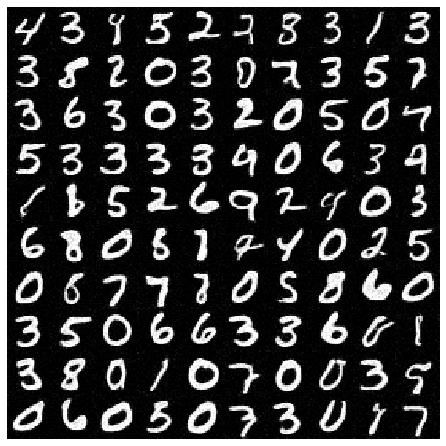

In [3]:
from sebm.eval import plot_samples, compress_tsne, plot_tsne
plot_samples(images_ebm, fs=6)

In [4]:
# data_dir = '../../../sebm_data/'
# num_classes = 102
# zs2, ys = compress_tsne(dataset, data_dir, ebm, device, data_noise_std, sample_size=None)
# plot_tsne(num_classes, zs2, ys, save_name='mnist_mean')

In [5]:
# zs2, ys = compress_tsne(dataset, data_dir, ebm, device, data_noise_std, sample_size=1)
# plot_tsne(num_classes, zs2, ys, save_name='mnist_sample')

In [6]:
from sebm.data import load_data
import numpy as np
import matplotlib.pyplot as plt


In [7]:
from sebm.eval import ll_hist
data_dir = '../../../sebm_data/'
dataset = 'mnist'
LLs_mnist = ll_hist(dataset, data_dir, ebm, device, data_noise_std)

dataset = 'fashionmnist'
LLs_fashionmnist = ll_hist(dataset, data_dir, ebm, device, data_noise_std)

Loading dataset=mnist...
Note: downsampling function is Resize(size=1, interpolation=PIL.Image.BILINEAR)
run test set..
Loading dataset=fashionmnist...
Note: downsampling function is Resize(size=1, interpolation=PIL.Image.BILINEAR)



Extracting ../../../sebm_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../../sebm_data/FashionMNIST/raw



Extracting ../../../sebm_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../../sebm_data/FashionMNIST/raw



Extracting ../../../sebm_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../../sebm_data/FashionMNIST/raw



Extracting ../../../sebm_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../sebm_data/FashionMNIST/raw
Processing...
Done!
run test set..


/home/hao/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


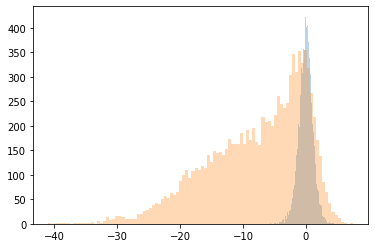

In [12]:
_ = plt.hist(LLs_mnist, bins=100, label='MNIST', alpha=.3)
_ = plt.hist(LLs_fashionmnist, bins=100, label='FashionMNIST', alpha=.3)